In [1]:
import os
import glob
import time
import pickle
import cv2
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from random import randint
from time import time
from tqdm import tqdm
import random

import collections
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.distributions import Categorical


from lib import dataset_factory_er21046
from lib import dataset_factory_er21046_v1
from lib import dataset_factory_er21046_v2
from lib import models as model_fuctory
from lib import loss_func
from lib import utils_er21046

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [278]:
# seed値を固定して乱数で決まる値を固定
seed = 42  
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)  
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [279]:
# 学習済みモデルのディレクトリ
load_path = "./results_er21046/depth40/train_200/2000epoch_lr0x001_NAdam_200samples_with_RND_sampler"
num_gauss = 1

with open('./new_dataset_er21046/train300/divide_ids/data_train_300.pickle', mode='br') as fi:
    id_train = pickle.load(fi)
id_train = id_train[0].tolist()
print(len(id_train))
print(id_train)

with open('./evaluate_data_er21046/train200_sampler_RNDMDN/divide_ids/data_test_100.pickle', mode='br') as fi:
    id_test = pickle.load(fi)
id_test = id_test[0].tolist()
print(len(id_test))
print(id_test)

#id_list = [i for i in range(160)] 
#print(id_train)
#print(id_test)


300
[187, 27, 47, 163, 58, 295, 143, 139, 285, 39, 210, 277, 214, 175, 239, 130, 161, 133, 145, 232, 96, 212, 273, 42, 148, 120, 67, 114, 31, 75, 105, 231, 267, 247, 1, 289, 208, 84, 16, 20, 221, 106, 176, 296, 172, 41, 137, 144, 204, 254, 18, 88, 174, 71, 220, 177, 275, 149, 81, 250, 83, 152, 185, 110, 154, 127, 269, 253, 157, 284, 128, 91, 258, 90, 211, 48, 294, 249, 103, 66, 199, 22, 72, 108, 112, 288, 228, 132, 207, 244, 107, 193, 281, 118, 64, 268, 123, 196, 205, 51, 198, 94, 55, 243, 135, 57, 38, 35, 200, 195, 136, 53, 179, 59, 26, 73, 270, 158, 278, 230, 80, 68, 43, 215, 191, 146, 160, 165, 8, 170, 87, 151, 183, 30, 131, 134, 93, 279, 13, 159, 227, 297, 189, 140, 86, 10, 166, 184, 101, 147, 29, 124, 241, 117, 169, 52, 109, 95, 100, 168, 190, 255, 99, 111, 261, 125, 272, 89, 264, 225, 155, 286, 119, 266, 142, 79, 248, 77, 44, 235, 164, 188, 216, 202, 6, 259, 9, 25, 12, 178, 229, 242, 240, 63, 23, 290, 287, 182, 156, 56, 17, 45, 201, 32, 251, 11, 19, 298, 113, 74, 197, 24, 263, 85

In [280]:
# データセット
train_data = dataset_factory_er21046_v2.RGBD_DATASET(root="./new_dataset_er21046/train300", use_ids = id_train, train=True, img_size=150, crop_size=140)
print("train_data : ", len(train_data))
test_data  = dataset_factory_er21046_v1.RGBD_DATASET(root="./evaluate_data_er21046/train200_sampler_RNDMDN", use_ids = id_test, train=False, img_size=150, crop_size=140)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=8,
                                           shuffle=True,
                                           num_workers=8,
                                           pin_memory=True,
                                           drop_last=True)
test_loader  = torch.utils.data.DataLoader(test_data,
                                           batch_size=8,
                                           shuffle=True,
                                           num_workers=8,
                                           pin_memory=True,
                                           drop_last=False)

Number of data :  300
target： 200
color ： 200
train_data :  200
Number of data :  100
./evaluate_data_er21046/train200_sampler_RNDMDN/color_crop/2025-04-09T17-41-01.png
./evaluate_data_er21046/train200_sampler_RNDMDN/color_crop/2025-04-09T17-41-01
./evaluate_data_er21046/train200_sampler_RNDMDN/color_crop/2025-04-09T17-01-43.png
./evaluate_data_er21046/train200_sampler_RNDMDN/color_crop/2025-04-09T17-01-43
./evaluate_data_er21046/train200_sampler_RNDMDN/color_crop/2025-04-09T17-36-52.png
./evaluate_data_er21046/train200_sampler_RNDMDN/color_crop/2025-04-09T17-36-52
./evaluate_data_er21046/train200_sampler_RNDMDN/color_crop/2025-04-09T16-50-32.png
./evaluate_data_er21046/train200_sampler_RNDMDN/color_crop/2025-04-09T16-50-32
./evaluate_data_er21046/train200_sampler_RNDMDN/color_crop/2025-04-09T17-56-32.png
./evaluate_data_er21046/train200_sampler_RNDMDN/color_crop/2025-04-09T17-56-32
./evaluate_data_er21046/train200_sampler_RNDMDN/color_crop/2025-04-09T18-06-51.png
./evaluate_data_er210

Train data
[2.56, 4.3, 2.83, 0.79, 1.63, 1.82, 1.29, 4.21, 1.3, 4.16, 3.86, 5.31, 7.51, 0.77, 4.37, 1.06, 5.32, 1.38, 1.38, 5.74, 6.88, 6.75, 0.47, 4.01, 7.9, 1.68, 4.17, 4.66, 1.99, 0.9, 1.82, 1.79, 5.88, 5.13, 4.67, 3.17, 3.05, 5.25, 0.46, 2.83, 2.28, 1.91, 5.65, 4.2, 6.45, 3.71, 4.27, 0.46, 1.56, 5.07, 4.22, 7.46, 2.39, 2.0, 7.0, 6.31, 3.91, 3.63, 2.74, 3.25, 4.83, 6.87, 3.36, 3.76, 4.81, 4.66, 3.41, 2.0, 2.55, 1.76, 2.11, 2.32, 6.89, 2.25, 4.4, 4.18, 3.77, 5.74, 3.28, 6.35, 3.56, 3.62, 1.95, 1.93, 1.01, 5.5, 0.13, 0.9, 1.49, 4.86, 5.75, 5.64, 1.78, 0.5, 5.0, 3.31, 2.19, 5.37, 4.38, 2.41, 1.29, 3.58, 3.77, 0.62, 3.78, 3.34, 3.57, 1.8, 2.69, 5.1, 2.1, 5.24, 5.85, 2.92, 2.64, 4.1, 3.47, 2.41, 6.68, 1.08, 3.48, 3.94, 2.58, 2.1, 4.27, 7.28, 5.0, 3.0, 2.77, 5.43, 2.85, 7.16, 7.28, 5.34, 4.57, 1.0, 2.94, 4.45, 7.77, 5.14, 3.5, 2.09, 3.92, 4.13, 2.64, 1.93, 0.75, 6.0, 7.14, 1.77, 2.92, 4.5, 5.67, 2.06, 2.61, 6.63, 6.53, 4.81, 6.58, 3.68, 7.73, 2.38, 4.37, 5.76, 1.94, 2.38, 4.14, 4.47, 4.09

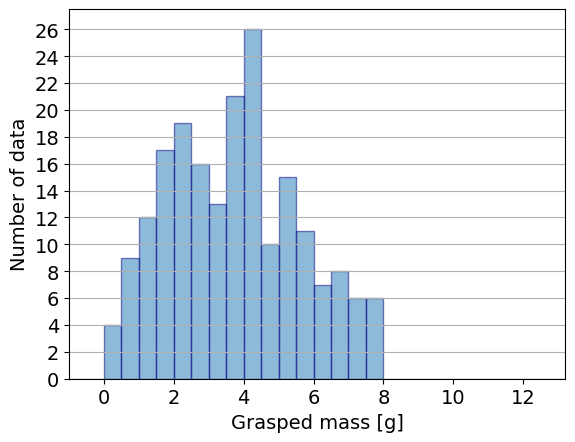

Test data (Aligned y-axis)


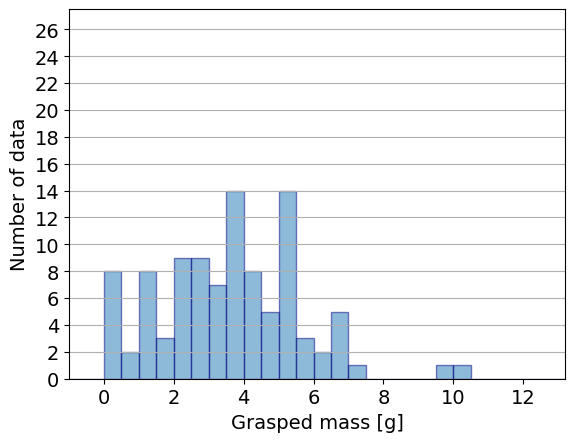

In [281]:
# Train data
print("Train data")
Y_train, X_train, _ = plt.hist(train_data.targets_list, alpha=0.5, ec='navy', bins=np.arange(-1, 12, 0.5))
plt.grid(axis='y')
plt.ylabel('Number of data')
plt.xlabel('Grasped mass [g]')
# 一旦プロットを閉じて最大値を確認
plt.close()
print(train_data.targets_list)

# Test data
print("Test data")
Y_test, X_test, _ = plt.hist(test_data.targets_list, alpha=0.5, ec='navy', bins=np.arange(-1, 12, 0.5))
plt.grid(axis='y')
plt.ylabel('Number of data')
plt.xlabel('Grasped mass [g]')
# 一旦プロットを閉じて最大値を確認
plt.close()

x_max = 12
y_max = 25
x_ticks = np.arange(0, x_max * 1.1 , 2)  # 1.0刻みの目盛り
y_ticks = np.arange(0, y_max * 1.1 , 2)  # 1.0刻みの目盛り

# 再プロット
print("Train data (Aligned y-axis)")
plt.hist(train_data.targets_list, alpha=0.5, ec='navy', bins=np.arange(-1, 19, 0.5))
plt.grid(axis='y')
plt.xlim(-1, x_max * 1.1)  # 少し余裕を持たせる
plt.ylim(0, y_max * 1.1)  # 少し余裕を持たせる
plt.xticks(x_ticks)  # y軸の目盛りを1.0間隔にする
plt.yticks(y_ticks)  # y軸の目盛りを1.0間隔にする
plt.ylabel('Number of data', fontsize=14)  # 文字サイズを大きくする
plt.xlabel('Grasped mass [g]', fontsize=14)  # 文字サイズを大きくする
plt.xticks(fontsize=14)  # x軸の目盛りのフォントサイズ変更
plt.yticks(fontsize=14)  # y軸の目盛りのフォントサイズ変更
#plt.savefig("train_data_histogram.png", bbox_inches="tight", dpi=300)  # dpi=300で高解像度に
plt.show()

print("Test data (Aligned y-axis)")
plt.hist(test_data.targets_list, alpha=0.5, ec='navy', bins=np.arange(-1, 19, 0.5))
plt.grid(axis='y')
plt.xlim(-1, x_max * 1.1)  # 少し余裕を持たせる
plt.ylim(0, y_max * 1.1)  # 少し余裕を持たせる
plt.xticks(x_ticks)  # y軸の目盛りを1.0間隔にする
plt.yticks(y_ticks)  # y軸の目盛りを1.0間隔にする
plt.ylabel('Number of data', fontsize=14)
plt.xlabel('Grasped mass [g]', fontsize=14)
plt.xticks(fontsize=14)  # x軸の目盛りのフォントサイズ変更
plt.yticks(fontsize=14)  # y軸の目盛りのフォントサイズ変更
plt.show()

In [282]:
# ネットワーク
net = model_fuctory.CNN_MDN(num_gaussians=num_gauss)
predict_net = model_fuctory.CNN_RND()
target_net  = model_fuctory.CNN_RND()

# 学習済み重みの読み込み
msg = net.load_state_dict(torch.load(os.path.join(load_path, 'checkpoint.pth'), map_location='cpu'))
print(msg)
msg = predict_net.load_state_dict(torch.load(os.path.join(load_path, 'predict_net.pth'), map_location='cpu'))
print(msg)
msg = target_net.load_state_dict(torch.load(os.path.join(load_path, 'target_net.pth'), map_location='cpu'))
print(msg)

# ネットワークをGPUへ
net = net.cuda()
predict_net = predict_net.cuda()
target_net  = target_net.cuda()

# RNDの損失式
criterion_rnd = nn.MSELoss(reduction='none').cuda()

<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>


## 学習用データに対する予測結果の評価

### 各データに対するMDNが予測した把持量と標準偏差，計測した把持量-予測した把持量を可視化

In [283]:
data_ids = 0
train_difference_mass_list = []
train_target_mass_list  = []
train_predict_mass_list = []
train_predict_sigma_list = []
train_rnd_score_list  = []
target_gaku_list = []

net.eval()
predict_net.eval()
target_net.eval()
with torch.no_grad():
    for image_rgb, image_depth, z_gripper, target, use_id, item in train_loader:
        # 各データをGPUへ
        image_rgb   = image_rgb.cuda()
        image_depth = image_depth.cuda()
        z_gripper   = z_gripper.cuda()
        target      = target.cuda()
        
        target_gaku_list.extend(target.detach().cpu().numpy().tolist())
        #print(target_gaku_list)
        
        # 把持深さと把持量のTensorをreshape : torch.Size([2]) -> torch.Size([2,1])
        z_gripper = z_gripper.reshape([z_gripper.size()[0],-1])
        target    = target.reshape([target.size()[0],-1])*0.001
        
        # ネットワークによる予測
        pi, sigma, mu = net(image_rgb, image_depth, 0*z_gripper)
        output_rnd = predict_net(image_rgb, image_depth)
        target_rnd = target_net(image_rgb, image_depth)
        loss_rnd   = criterion_rnd(output_rnd, target_rnd)
        
        if pi.shape[-1] >= 1:
            # 使用するガウス分布をpiに基づいて決定
            pis = Categorical(pi).sample().view(pi.size(0), 1, 1)
            # 決定したガウス分布に対応する平均値と標準偏差の値をgatherにより取り出し
            variance_samples = sigma.gather(1, pis).detach().squeeze()#.item()
            mean_samples = mu.detach().gather(1, pis).squeeze()#.item()
            
        for i in range(len(mu)):
            data_ids += 1
            if pi.shape[-1] >= 1:
                variance = variance_samples[i].item()
                mean = mean_samples[i].item()
            else:
                variance = sigma[i].item()
                mean = mu[i].item()
            #print("data : ", data_ids)
            #print("model prediction [g] : {:.5f} , standard deviation : {:.10f}".format(mean*1000, variance))
            #print("target mass [g]      : {:.5f}".format((target[i].item())*1000))
            #print("difference mass [g]  : {:.5f}".format((target[i].item()-mean)*1000))
            #print("RND Score (MSE)       : {:.10f}\n".format(loss_rnd[i].mean().item()))
            train_target_mass_list.append(target[i].item()*1000)
            train_predict_mass_list.append(mean*1000)
            train_difference_mass_list.append( (target[i].item()-mean)*1000 )
            train_predict_sigma_list.append( variance*1000 )
            train_rnd_score_list.append( loss_rnd[i].mean().item() )
            
            # 画像の可視化
            """
            image = torch.permute(image_rgb[i], (1, 2, 0))
            depth = torch.permute(image_depth[i], (1, 2, 0))
            
            fig = plt.figure(figsize=(9,3))
            ax1 = fig.add_subplot(1, 2, 1)
            ax1.imshow(image.cpu())
            ax1.set_title("image")
            
            ax2 = fig.add_subplot(1, 2, 2)
            aximg = ax2.imshow(depth.cpu())
            fig.colorbar(aximg, ax=ax2)
            ax2.set_title("raw_depth")
            
            plt.show()
            #"""


### 各データに対する計測した把持量-予測した把持量をヒストグラムで表現
横軸：計測した把持量-予測した把持量  
縦軸：データ数

In [284]:
acc_count_pm1  = 0
acc_count_pm5  = 0
acc_count_pm10 = 0
acc_count_pm15 = 0
acc_count_pm20 = 0
acc_count_pm30 = 0
acc_count_pm40 = 0
acc_count_pm50 = 0
for i in range(len(train_target_mass_list)):
    if (train_target_mass_list[i]-train_target_mass_list[i]*0.01) <= train_predict_mass_list[i]:
        if (train_target_mass_list[i]+train_target_mass_list[i]*0.01) >= train_predict_mass_list[i]:
            acc_count_pm1 += 1
            
    if (train_target_mass_list[i]-train_target_mass_list[i]*0.05) <= train_predict_mass_list[i]:
        if (train_target_mass_list[i]+train_target_mass_list[i]*0.05) >= train_predict_mass_list[i]:
            acc_count_pm5 += 1
            
    if (train_target_mass_list[i]-train_target_mass_list[i]*0.10) <= train_predict_mass_list[i]:
        if (train_target_mass_list[i]+train_target_mass_list[i]*0.10) >= train_predict_mass_list[i]:
            acc_count_pm10 += 1
            
    if (train_target_mass_list[i]-train_target_mass_list[i]*0.15) <= train_predict_mass_list[i]:
        if (train_target_mass_list[i]+train_target_mass_list[i]*0.15) >= train_predict_mass_list[i]:
            acc_count_pm15 += 1
            
    if (train_target_mass_list[i]-train_target_mass_list[i]*0.20) <= train_predict_mass_list[i]:
        if (train_target_mass_list[i]+train_target_mass_list[i]*0.20) >= train_predict_mass_list[i]:
            acc_count_pm20 += 1
            
    if (train_target_mass_list[i]-train_target_mass_list[i]*0.30) <= train_predict_mass_list[i]:
        if (train_target_mass_list[i]+train_target_mass_list[i]*0.30) >= train_predict_mass_list[i]:
            acc_count_pm30 += 1
            
    if (train_target_mass_list[i]-train_target_mass_list[i]*0.40) <= train_predict_mass_list[i]:
        if (train_target_mass_list[i]+train_target_mass_list[i]*0.40) >= train_predict_mass_list[i]:
            acc_count_pm40 += 1
            
    if (train_target_mass_list[i]-train_target_mass_list[i]*0.50) <= train_predict_mass_list[i]:
        if (train_target_mass_list[i]+train_target_mass_list[i]*0.50) >= train_predict_mass_list[i]:
            acc_count_pm50 += 1
    #print(train_target_mass_list[i])
    #print(train_predict_mass_list[i])
print("acc +-  1 % : ", acc_count_pm1/len(train_target_mass_list) * 100)
print("acc +-  5 % : ", acc_count_pm5/len(train_target_mass_list) * 100)
print("acc +- 10 % : ", acc_count_pm10/len(train_target_mass_list) * 100)
print("acc +- 15 % : ", acc_count_pm15/len(train_target_mass_list) * 100)
print("acc +- 20 % : ", acc_count_pm20/len(train_target_mass_list) * 100)
print("acc +- 30 % : ", acc_count_pm30/len(train_target_mass_list) * 100)
print("acc +- 40 % : ", acc_count_pm40/len(train_target_mass_list) * 100)
print("acc +- 50 % : ", acc_count_pm50/len(train_target_mass_list) * 100)

acc +-  1 % :  29.5
acc +-  5 % :  82.5
acc +- 10 % :  95.5
acc +- 15 % :  97.0
acc +- 20 % :  98.5
acc +- 30 % :  99.5
acc +- 40 % :  99.5
acc +- 50 % :  100.0


In [285]:
acc_count_pm1g  = 0
acc_count_pm5g  = 0
acc_count_pm10g = 0
acc_count_pm15g = 0
acc_count_pm20g = 0

for i in range(len(train_target_mass_list)):
    diff_g = abs(train_predict_mass_list[i] - train_target_mass_list[i])
    if diff_g <= 0.5:
        acc_count_pm1g += 1
    if diff_g <= 1.0:
        acc_count_pm5g += 1
    if diff_g <= 1.5:
        acc_count_pm10g += 1
    if diff_g <= 2.0:
        acc_count_pm15g += 1
    if diff_g <= 2.5:
        acc_count_pm20g += 1

print("acc +- 0.5 g : ", acc_count_pm1g/len(train_target_mass_list) * 100)
print("acc +- 1.0 g : ", acc_count_pm5g/len(train_target_mass_list) * 100)
print("acc +- 1.5 g : ", acc_count_pm10g/len(train_target_mass_list) * 100)
print("acc +- 2.0 g : ", acc_count_pm15g/len(train_target_mass_list) * 100)
print("acc +- 2.5 g : ", acc_count_pm20g/len(train_target_mass_list) * 100)

acc +- 0.5 g :  99.0
acc +- 1.0 g :  100.0
acc +- 1.5 g :  100.0
acc +- 2.0 g :  100.0
acc +- 2.5 g :  100.0


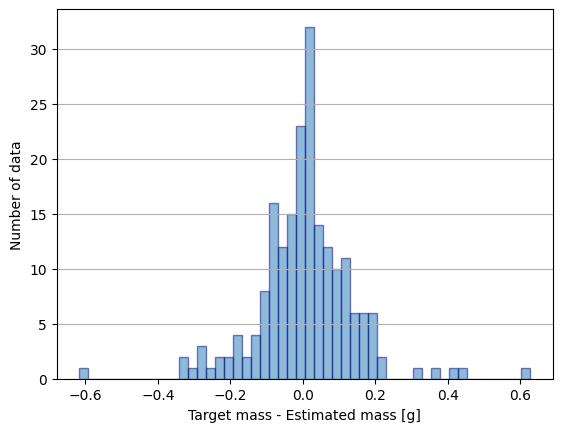

In [286]:
# 実際の把持量 - モデルの予測(平均値) の ヒストグラム
Y, X, _ = plt.hist(train_difference_mass_list, bins=50, alpha=0.5, ec='navy')
plt.grid(axis='y')
plt.ylabel('Number of data')
plt.xlabel('Target mass - Estimated mass [g]')

#plt.xlim(-54.87830035854131, 54.87830035854131)
#plt.ylim(0.0, 48.3)
#plt.xticks([-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50])
#plt.yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45])

#ax = plt.gca()
#x_range = ax.get_xlim()
#y_range = ax.get_ylim()
#print(x_range, y_range)

#plt.savefig("train_difference_mass_6000epoch.pdf")
plt.show()

### 各データに対する「計測した把持量-予測した把持量」と「予測した標準偏差」の関係を散布図で表現
横軸：計測した把持量-MDNが予測した把持量  
縦軸：MDNが予測した標準偏差

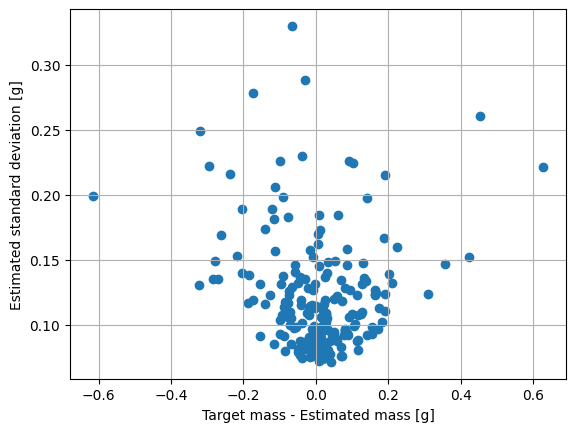

In [287]:
# 「計測した把持量-予測した把持量」 と 「予測した標準偏差」 の 散布図
plt.scatter(train_difference_mass_list, train_predict_sigma_list)
plt.grid()
plt.ylabel('Estimated standard deviation [g]')
plt.xlabel('Target mass - Estimated mass [g]')
#plt.savefig("train_scatter_mass_sd_6000epoch.pdf")
plt.show()

横軸：計測した把持量-MDNが予測した把持量  
縦軸：RNDのスコア

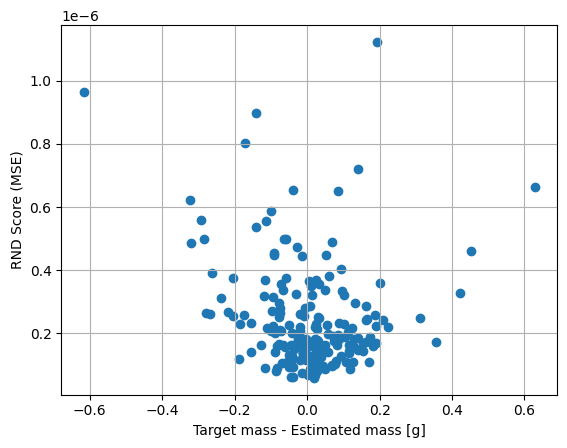

In [288]:
plt.scatter(train_difference_mass_list, train_rnd_score_list)
plt.grid()
plt.ylabel('RND Score (MSE)')
plt.xlabel('Target mass - Estimated mass [g]')
#plt.savefig("train_scatter_mass_sd_6000epoch.pdf")
plt.show()

### 学習用データにおけるトレイ全体に対する把持量推定
1. トレイ全体をいくつかの領域に分割  
2. 分割した領域ごとに把持量と標準偏差を予測  
3. 予測した把持量と標準偏差をヒートマップ形式で可視化

## テスト用データに対する予測結果の評価

### 各データに対するMDNが予測した把持量と標準偏差，計測した把持量-予測した把持量を可視化

In [289]:
data_ids = 0
test_difference_mass_list = []
test_target_mass_list = []
test_predict_mass_list = []
test_predict_sigma_list = []
test_rnd_score_list  = []
target_test_list = []

net.eval()
predict_net.eval()
target_net.eval()
with torch.no_grad():
    for image_rgb, image_depth, z_gripper, target, use_id, item in test_loader:
        # 各データをGPUへ
        image_rgb   = image_rgb.cuda()
        image_depth = image_depth.cuda()
        z_gripper   = z_gripper.cuda()
        target      = target.cuda()
        
        target_test_list.extend(target.detach().cpu().numpy().tolist())
        
        # 把持深さと把持量のTensorをreshape : torch.Size([2]) -> torch.Size([2,1])
        z_gripper = z_gripper.reshape([z_gripper.size()[0],-1])
        target    = target.reshape([target.size()[0],-1]) * 0.001
        
        # ネットワークによる予測
        pi, sigma, mu = net(image_rgb, image_depth, 0*z_gripper)
        output_rnd = predict_net(image_rgb, image_depth)
        target_rnd = target_net(image_rgb, image_depth)
        loss_rnd   = criterion_rnd(output_rnd, target_rnd)
        
        if pi.shape[-1] >= 2:
            # 使用するガウス分布をpiに基づいて決定
            pis = Categorical(pi).sample().view(pi.size(0), 1, 1)
            # 決定したガウス分布に対応する平均値と標準偏差の値をgatherにより取り出し
            variance_samples = sigma.gather(1, pis).detach().squeeze()#.item()
            mean_samples = mu.detach().gather(1, pis).squeeze()#.item()
            
        for i in range(len(mu)):
            data_ids += 1
            if pi.shape[-1] >= 2:
                variance = variance_samples[i].item()
                mean = mean_samples[i].item()
            else:
                variance = sigma[i].item()
                mean = mu[i].item()

            #print("data : ", data_ids)
            #print("model prediction [g] : {:.5f} , standard deviation : {:.5f}".format(mean*1000, variance))
            #print("targe mass [g]       : {:.5f}".format((target[i].item()))*1000)
            #print("difference mass [g]  : {:.5f}\n".format((target[i].item()-mean))*1000)
            #print("RND Score (MSE)       : {:.10f}\n".format(loss_rnd[i].mean().item()))
            test_target_mass_list.append(target[i].item()*1000)
            test_predict_mass_list.append(mean*1000)
            test_difference_mass_list.append( (target[i].item()-mean)*1000)
            test_predict_sigma_list.append( variance*1000)
            test_rnd_score_list.append( loss_rnd[i].mean().item() )
            
            
            # 画像の可視化
            """
            image = torch.permute(image_rgb[i], (1, 2, 0))
            depth = torch.permute(image_depth[i], (1, 2, 0))
            
            fig = plt.figure(figsize=(9,3))
            ax1 = fig.add_subplot(1, 2, 1)
            ax1.imshow(image.cpu())
            ax1.set_title("image")
            
            ax2 = fig.add_subplot(1, 2, 2)
            aximg = ax2.imshow(depth.cpu())
            fig.colorbar(aximg, ax=ax2)
            ax2.set_title("raw_depth")
            
            plt.show()
            #"""
print(test_target_mass_list)
print(test_predict_mass_list)

[5.270000081509352, 5.060000345110893, 5.130000412464142, 2.4400001857429743, 2.950000111013651, 4.000000189989805, 2.7100001461803913, 2.680000150576234, 2.360000042244792, 4.000000189989805, 3.54000017978251, 3.8400001358240843, 0.1500000071246177, 2.560000168159604, 4.210000392049551, 2.2200001403689384, 6.370000075548887, 1.0000000474974513, 4.980000201612711, 5.350000225007534, 2.0200000144541264, 1.0000000474974513, 3.060000017285347, 2.9800001066178083, 0.0, 0.5400000372901559, 0.0, 1.4100000262260437, 2.360000042244792, 6.520000286400318, 3.6500003188848495, 3.640000242739916, 4.110000096261501, 4.699999932199717, 5.280000623315573, 1.2400000123307109, 3.2400002237409353, 2.8600001242011786, 6.8800002336502075, 5.360000301152468, 1.2000000569969416, 5.000000353902578, 6.690000183880329, 4.8100003041327, 3.750000149011612, 3.920000046491623, 4.3400004506111145, 5.820000544190407, 2.460000105202198, 2.990000182762742, 3.7800001446157694, 3.000000026077032, 4.620000254362822, 4.00

In [298]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grasp_scatter(test_target_mass_list, test_predict_mass_list, data_dir):
    """
    実際の把持量を横軸、予測把持量を縦軸にとった散布図を作成

    Parameters:
    test_target_mass_list (list): 実際の把持量のリスト
    test_predict_mass_list (list): 予測把持量のリスト
    data_dir (str): 保存するファイル名の識別子
    """
    if not test_target_mass_list or not test_predict_mass_list:
        print("Error: test_target_mass_list or test_predict_mass_list is empty.")
        return
    
    # 散布図の作成
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(test_target_mass_list, test_predict_mass_list, c="blue", label="Grasp Data", alpha=0.7, edgecolors="black")

    # 理想的な y=x の線を追加
    ax.plot([0, 14], [0, 14], linestyle="--", color="red", label="Ideal (y=x)")

    # 軸範囲を 0より少し下からにする（でも-0.5の目盛りは出さない）
    ax.set_xlim(-0.7, 14)
    ax.set_ylim(-0.7, 14)

    # 目盛りを 0 から表示（-0.5の目盛りを出さない）
    ax.set_xticks(np.arange(0, 15, 2))
    ax.set_yticks(np.arange(0, 15, 2))
    
    """
    # 理想的な y=x の線を追加
    min_val = min(min(test_target_mass_list), min(test_predict_mass_list))
    max_val = max(max(test_target_mass_list), max(test_predict_mass_list))
    ax.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red", label="Ideal (y=x)")
    """
    
    # 軸ラベルとタイトル
    plt.xlabel("Actual Grasp Mass [g]")  # 実際の把持量 (横軸)
    plt.ylabel("Estimated Grasp Mass [g]")  # 予測把持量 (縦軸)
    #plt.title("Actual vs. Estimated Grasp Mass")
    plt.legend()
    plt.grid(True)

    # 保存
    #output_path = f"./output/{data_dir}_scatter_v1.pdf"
    #plt.savefig(output_path, bbox_inches="tight", pad_inches=0.1)
    plt.show()

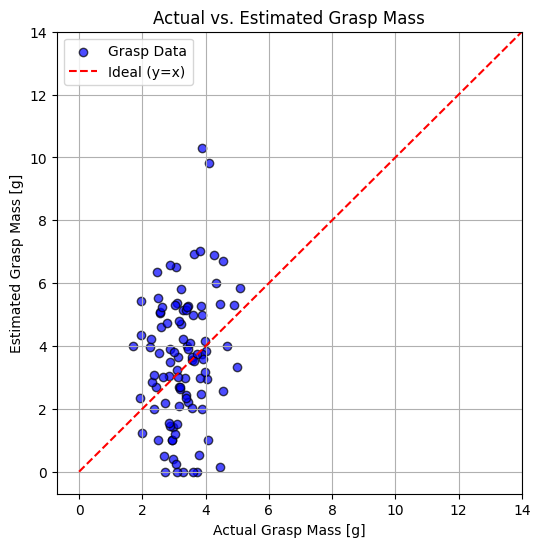

In [299]:
plot_grasp_scatter(test_predict_mass_list, test_target_mass_list, data_dir="new_sampler_RNDMDN")

In [311]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grasp_scatter(test_predict_mass_list, test_target_mass_list, data_dir):
    """
    実際の把持量を横軸、予測把持量を縦軸にとった散布図を作成し、相関係数と回帰直線を表示

    Parameters:
    test_target_mass_list (list): 実際の把持量のリスト
    test_predict_mass_list (list): 予測把持量のリスト
    data_dir (str): 保存するファイル名の識別子
    """
    if not test_predict_mass_list or not test_target_mass_list:
        print("Error: test_target_mass_list or test_predict_mass_list is empty.")
        return
    
    x = np.array(test_predict_mass_list)
    y = np.array(test_target_mass_list)

    # 相関係数の計算
    corr_coef = np.corrcoef(x, y)[0, 1]

    # 回帰直線の係数を計算（一次式：y = a*x + b）
    #z = np.polyfit(x, y, 1)
    #p = np.poly1d(z)

    # 散布図の作成
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(x, y, c="blue", label="Grasp Data", alpha=0.7, edgecolors="black")

    # 理想的な y=x の線
    ax.plot([0, 14], [0, 14], linestyle="--", color="red", label="Ideal (y=x)")

    # 回帰直線の描画
    #ax.plot(x, p(x), color="green", linestyle="-", label=f"Regression Line")

    # 軸設定
    ax.set_xlim(-0.7, 14)
    ax.set_ylim(-0.7, 14)
    ax.set_xticks(np.arange(0, 15, 2))
    ax.set_yticks(np.arange(0, 15, 2))

    # ラベルやタイトル
    plt.xlabel("Actual Grasp Mass [g]")
    plt.ylabel("Estimated Grasp Mass [g]")
    plt.title(f"Actual vs. Estimated Grasp Mass\nCorrelation Coefficient: {corr_coef:.3f}")
    plt.legend()
    plt.grid(True)

    # 保存
    #output_path = f"./output/{data_dir}_scatter_v2.pdf"
    #plt.savefig(output_path, bbox_inches="tight", pad_inches=0.1)
    plt.show()


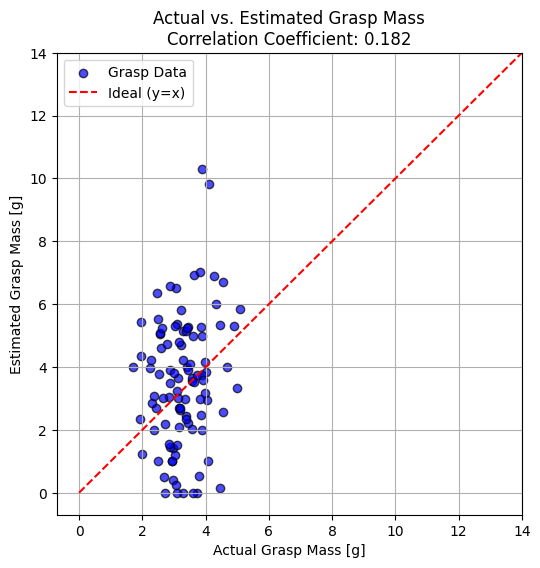

In [312]:
plot_grasp_scatter(test_predict_mass_list, test_target_mass_list, data_dir="new_sampler_RNDMDN")

### 各データに対する計測した把持量-予測した把持量をヒストグラムで表現
横軸：計測した把持量-予測した把持量  
縦軸：データ数

In [266]:
path_list = sorted(glob.glob( "./evaluate_data_er21046/train200_sampler_RNDMDN/color/*"))

gram_e_list = []
gram_j_list = []

for i in range(len(path_list)):
    image_path = path_list[i]
    base_path = os.path.splitext(image_path)[0]
    
    # gram
    gram_path = base_path.split('/')
    gram_path[3] = "grams_txt" 
    gram_path = os.path.join(*gram_path) + ".csv"
    grams = np.genfromtxt(gram_path, delimiter=',')
    gram_e  = grams[1, 0]
    gram_j = grams[1, 1]
    
    gram_e_list.append(gram_e)
    gram_j_list.append(gram_j)

#print(gram_e_list)
#print(len(gram_e_list))
#print(gram_j_list)
#print(len(gram_j_list))
     
acc_count_pm1  = 0
acc_count_pm5  = 0
acc_count_pm10 = 0
acc_count_pm15 = 0
acc_count_pm20 = 0
acc_count_pm30 = 0
acc_count_pm40 = 0
acc_count_pm50 = 0

for i in range(len(gram_j_list)):
    if (gram_j_list[i]-gram_j_list[i]*0.01) <= gram_e_list[i]:
        if (gram_j_list[i]+gram_j_list[i]*0.01) >= gram_e_list[i]:
            acc_count_pm1 += 1
            
    if (gram_j_list[i]-gram_j_list[i]*0.05) <= gram_e_list[i]:
        if (gram_j_list[i]+gram_j_list[i]*0.05) >= gram_e_list[i]:
            acc_count_pm5 += 1
            
    if (gram_j_list[i]-gram_j_list[i]*0.10) <= gram_e_list[i]:
        if (gram_j_list[i]+gram_j_list[i]*0.10) >= gram_e_list[i]:
            acc_count_pm10 += 1
    
    if (gram_j_list[i]-gram_j_list[i]*0.15) <= gram_e_list[i]:
        if (gram_j_list[i]+gram_j_list[i]*0.15) >= gram_e_list[i]:
            acc_count_pm15 += 1
            
    if (gram_j_list[i]-gram_j_list[i]*0.20) <= gram_e_list[i]:
        if (gram_j_list[i]+gram_j_list[i]*0.20) >= gram_e_list[i]:
            acc_count_pm20 += 1
            
    if (gram_j_list[i]-gram_j_list[i]*0.30) <= gram_e_list[i]:
        if (gram_j_list[i]+gram_j_list[i]*0.30) >= gram_e_list[i]:
            acc_count_pm30 += 1
            
    if (gram_j_list[i]-gram_j_list[i]*0.40) <= gram_e_list[i]:
        if (gram_j_list[i]+gram_j_list[i]*0.40) >= gram_e_list[i]:
            acc_count_pm40 += 1
            
    if (gram_j_list[i]-gram_j_list[i]*0.50) <= gram_e_list[i]:
        if (gram_j_list[i]+gram_j_list[i]*0.50) >= gram_e_list[i]:
            acc_count_pm50 += 1
    
    
            
print("acc +-  1 % : ", acc_count_pm1/len(gram_j_list) * 100)
print("acc +-  5 % : ", acc_count_pm5/len(gram_j_list) * 100)
print("acc +- 10 % : ", acc_count_pm10/len(gram_j_list) * 100)
print("acc +- 15 % : ", acc_count_pm15/len(gram_j_list) * 100)
print("acc +- 20 % : ", acc_count_pm20/len(gram_j_list) * 100)
print("acc +- 30 % : ", acc_count_pm30/len(gram_j_list) * 100)
print("acc +- 40 % : ", acc_count_pm40/len(gram_j_list) * 100)
print("acc +- 50 % : ", acc_count_pm50/len(gram_j_list) * 100)

acc +-  1 % :  2.0
acc +-  5 % :  9.0
acc +- 10 % :  13.0
acc +- 15 % :  20.0
acc +- 20 % :  28.000000000000004
acc +- 30 % :  41.0
acc +- 40 % :  51.0
acc +- 50 % :  63.0


In [267]:
acc_count_pm1g  = 0
acc_count_pm5g  = 0
acc_count_pm10g = 0
acc_count_pm15g = 0
acc_count_pm20g = 0
acc_count_pm25g = 0
acc_count_pm30g = 0
acc_count_pm35g = 0
acc_count_pm40g = 0
acc_count_pm45g = 0
acc_count_pm50g = 0
acc_count_pm55g = 0
acc_count_pm60g = 0
acc_count_pm65g = 0
acc_count_pm70g = 0

for i in range(len(gram_j_list)):
    diff_g = abs(gram_j_list[i] - gram_e_list[i])
    if diff_g <= 0.1:
        acc_count_pm1g += 1
    if diff_g <= 0.5:
        acc_count_pm5g += 1
    if diff_g <= 1.0:
        acc_count_pm10g += 1
    if diff_g <= 1.5:
        acc_count_pm15g += 1
    if diff_g <= 2.0:
        acc_count_pm20g += 1
    if diff_g <= 2.5:
        acc_count_pm25g += 1
    if diff_g <= 3.0:
        acc_count_pm30g += 1  
    if diff_g <= 3.5:
        acc_count_pm35g += 1  
    if diff_g <= 4.0:
        acc_count_pm40g += 1 
    if diff_g <= 4.5:
        acc_count_pm45g += 1 
    if diff_g <= 5.0:
        acc_count_pm50g += 1  
    if diff_g <= 5.5:
        acc_count_pm55g += 1  
    if diff_g <= 6.0:
        acc_count_pm60g += 1    
    if diff_g <= 6.5:
        acc_count_pm65g += 1  
    if diff_g <= 7.0:
        acc_count_pm70g += 1  
        
print("acc +- 0.1 g : ", acc_count_pm1g/len(gram_j_list) * 100)
print("acc +- 0.5 g : ", acc_count_pm5g/len(gram_j_list) * 100)
print("acc +- 1.0 g : ", acc_count_pm10g/len(gram_j_list) * 100)
print("acc +- 1.5 g : ", acc_count_pm15g/len(gram_j_list) * 100)
print("acc +- 2.0 g : ", acc_count_pm20g/len(gram_j_list) * 100)
print("acc +- 2.5 g : ", acc_count_pm25g/len(gram_j_list) * 100)
print("acc +- 3.0 g : ", acc_count_pm30g/len(gram_j_list) * 100)
print("acc +- 3.5 g : ", acc_count_pm35g/len(gram_j_list) * 100)
print("acc +- 4.0 g : ", acc_count_pm40g/len(gram_j_list) * 100)
print("acc +- 4.5 g : ", acc_count_pm45g/len(gram_j_list) * 100)
print("acc +- 5.0 g : ", acc_count_pm50g/len(gram_j_list) * 100)
print("acc +- 5.5 g : ", acc_count_pm55g/len(gram_j_list) * 100)
print("acc +- 6.0 g : ", acc_count_pm60g/len(gram_j_list) * 100)
print("acc +- 6.5 g : ", acc_count_pm65g/len(gram_j_list) * 100)
print("acc +- 7.0 g : ", acc_count_pm70g/len(gram_j_list) * 100)

acc +- 0.1 g :  3.0
acc +- 0.5 g :  20.0
acc +- 1.0 g :  38.0
acc +- 1.5 g :  52.0
acc +- 2.0 g :  69.0
acc +- 2.5 g :  77.0
acc +- 3.0 g :  84.0
acc +- 3.5 g :  92.0
acc +- 4.0 g :  97.0
acc +- 4.5 g :  98.0
acc +- 5.0 g :  98.0
acc +- 5.5 g :  98.0
acc +- 6.0 g :  99.0
acc +- 6.5 g :  100.0
acc +- 7.0 g :  100.0


In [268]:
acc_count_pm1  = 0
acc_count_pm5  = 0
acc_count_pm10 = 0
acc_count_pm15 = 0
acc_count_pm20 = 0
acc_count_pm30 = 0
acc_count_pm40 = 0
acc_count_pm50 = 0
for i in range(len(test_target_mass_list)):
    if (test_target_mass_list[i]-test_target_mass_list[i]*0.01) <= test_predict_mass_list[i]:
        if (test_target_mass_list[i]+test_target_mass_list[i]*0.01) >= test_predict_mass_list[i]:
            acc_count_pm1 += 1
            
    if (test_target_mass_list[i]-test_target_mass_list[i]*0.05) <= test_predict_mass_list[i]:
        if (test_target_mass_list[i]+test_target_mass_list[i]*0.05) >= test_predict_mass_list[i]:
            acc_count_pm5 += 1
            
    if (test_target_mass_list[i]-test_target_mass_list[i]*0.10) <= test_predict_mass_list[i]:
        if (test_target_mass_list[i]+test_target_mass_list[i]*0.10) >= test_predict_mass_list[i]:
            acc_count_pm10 += 1
    
    if (test_target_mass_list[i]-test_target_mass_list[i]*0.15) <= test_predict_mass_list[i]:
        if (test_target_mass_list[i]+test_target_mass_list[i]*0.15) >= test_predict_mass_list[i]:
            acc_count_pm15 += 1
            
    if (test_target_mass_list[i]-test_target_mass_list[i]*0.20) <= test_predict_mass_list[i]:
        if (test_target_mass_list[i]+test_target_mass_list[i]*0.20) >= test_predict_mass_list[i]:
            acc_count_pm20 += 1
            
    if (test_target_mass_list[i]-test_target_mass_list[i]*0.30) <= test_predict_mass_list[i]:
        if (test_target_mass_list[i]+test_target_mass_list[i]*0.30) >= test_predict_mass_list[i]:
            acc_count_pm30 += 1
            
    if (test_target_mass_list[i]-test_target_mass_list[i]*0.40) <= test_predict_mass_list[i]:
        if (test_target_mass_list[i]+test_target_mass_list[i]*0.40) >= test_predict_mass_list[i]:
            acc_count_pm40 += 1
            
    if (test_target_mass_list[i]-test_target_mass_list[i]*0.50) <= test_predict_mass_list[i]:
        if (test_target_mass_list[i]+test_target_mass_list[i]*0.50) >= test_predict_mass_list[i]:
            acc_count_pm50 += 1
    
    
            
print("acc +-  1 % : ", acc_count_pm1/len(test_target_mass_list) * 100)
print("acc +-  5 % : ", acc_count_pm5/len(test_target_mass_list) * 100)
print("acc +- 10 % : ", acc_count_pm10/len(test_target_mass_list) * 100)
print("acc +- 15 % : ", acc_count_pm15/len(test_target_mass_list) * 100)
print("acc +- 20 % : ", acc_count_pm20/len(test_target_mass_list) * 100)
print("acc +- 30 % : ", acc_count_pm30/len(test_target_mass_list) * 100)
print("acc +- 40 % : ", acc_count_pm40/len(test_target_mass_list) * 100)
print("acc +- 50 % : ", acc_count_pm50/len(test_target_mass_list) * 100)

#print(test_target_mass_list)
#print(len(test_target_mass_list))
#print("")
#print(test_predict_mass_list)

acc +-  1 % :  2.0
acc +-  5 % :  9.0
acc +- 10 % :  13.0
acc +- 15 % :  19.0
acc +- 20 % :  28.000000000000004
acc +- 30 % :  40.0
acc +- 40 % :  51.0
acc +- 50 % :  65.0


In [269]:
acc_count_pm1g  = 0
acc_count_pm5g  = 0
acc_count_pm10g = 0
acc_count_pm15g = 0
acc_count_pm20g = 0
acc_count_pm25g = 0
acc_count_pm30g = 0
acc_count_pm35g = 0
acc_count_pm40g = 0
acc_count_pm45g = 0
acc_count_pm50g = 0
acc_count_pm55g = 0
acc_count_pm60g = 0
acc_count_pm65g = 0
acc_count_pm70g = 0

for i in range(len(test_target_mass_list)):
    diff_g = abs(test_predict_mass_list[i] - test_target_mass_list[i])
    if diff_g <= 0.1:
        acc_count_pm1g += 1
    if diff_g <= 0.5:
        acc_count_pm5g += 1
    if diff_g <= 1.0:
        acc_count_pm10g += 1
    if diff_g <= 1.5:
        acc_count_pm15g += 1
    if diff_g <= 2.0:
        acc_count_pm20g += 1
    if diff_g <= 2.5:
        acc_count_pm25g += 1
    if diff_g <= 3.0:
        acc_count_pm30g += 1  
    if diff_g <= 3.5:
        acc_count_pm35g += 1  
    if diff_g <= 4.0:
        acc_count_pm40g += 1 
    if diff_g <= 4.5:
        acc_count_pm45g += 1 
    if diff_g <= 5.0:
        acc_count_pm50g += 1  
    if diff_g <= 5.5:
        acc_count_pm55g += 1  
    if diff_g <= 6.0:
        acc_count_pm60g += 1    
    if diff_g <= 6.5:
        acc_count_pm65g += 1  
    if diff_g <= 7.0:
        acc_count_pm70g += 1  
        
print("acc +- 0.1 g : ", acc_count_pm1g/len(test_target_mass_list) * 100)
print("acc +- 0.5 g : ", acc_count_pm5g/len(test_target_mass_list) * 100)
print("acc +- 1.0 g : ", acc_count_pm10g/len(test_target_mass_list) * 100)
print("acc +- 1.5 g : ", acc_count_pm15g/len(test_target_mass_list) * 100)
print("acc +- 2.0 g : ", acc_count_pm20g/len(test_target_mass_list) * 100)
print("acc +- 2.5 g : ", acc_count_pm25g/len(test_target_mass_list) * 100)
print("acc +- 3.0 g : ", acc_count_pm30g/len(test_target_mass_list) * 100)
print("acc +- 3.5 g : ", acc_count_pm35g/len(test_target_mass_list) * 100)
print("acc +- 4.0 g : ", acc_count_pm40g/len(test_target_mass_list) * 100)
print("acc +- 4.5 g : ", acc_count_pm45g/len(test_target_mass_list) * 100)
print("acc +- 5.0 g : ", acc_count_pm50g/len(test_target_mass_list) * 100)
print("acc +- 5.5 g : ", acc_count_pm55g/len(test_target_mass_list) * 100)
print("acc +- 6.0 g : ", acc_count_pm60g/len(test_target_mass_list) * 100)
print("acc +- 6.5 g : ", acc_count_pm65g/len(test_target_mass_list) * 100)
print("acc +- 7.0 g : ", acc_count_pm70g/len(test_target_mass_list) * 100)

acc +- 0.1 g :  3.0
acc +- 0.5 g :  20.0
acc +- 1.0 g :  37.0
acc +- 1.5 g :  51.0
acc +- 2.0 g :  69.0
acc +- 2.5 g :  77.0
acc +- 3.0 g :  84.0
acc +- 3.5 g :  93.0
acc +- 4.0 g :  97.0
acc +- 4.5 g :  98.0
acc +- 5.0 g :  98.0
acc +- 5.5 g :  98.0
acc +- 6.0 g :  99.0
acc +- 6.5 g :  100.0
acc +- 7.0 g :  100.0


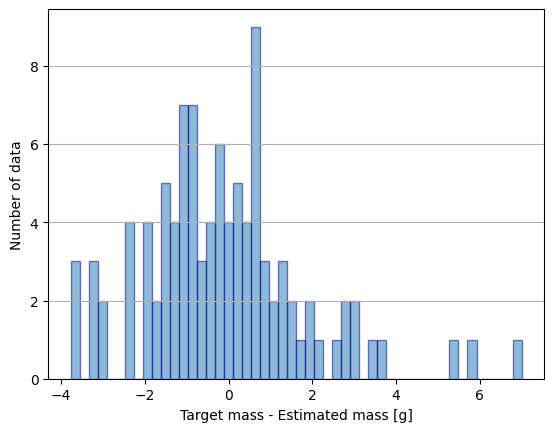

In [228]:
# 実際の把持量 - モデルの予測(平均値) の ヒストグラム
Y, X, _ = plt.hist(test_difference_mass_list, bins=50, alpha=0.5, ec='navy')
plt.grid(axis='y')
#plt.yticks([0, 1, 2, 3, 4])
plt.ylabel('Number of data')
plt.xlabel('Target mass - Estimated mass [g]')
#plt.savefig("test_difference_mass_500epoch.pdf")
plt.show()

### 各データに対する「計測した把持量-予測した把持量」と「予測した標準偏差」の関係を散布図で表現
横軸：計測した把持量-MDNが予測した把持量  
縦軸：MDNが予測した標準偏差

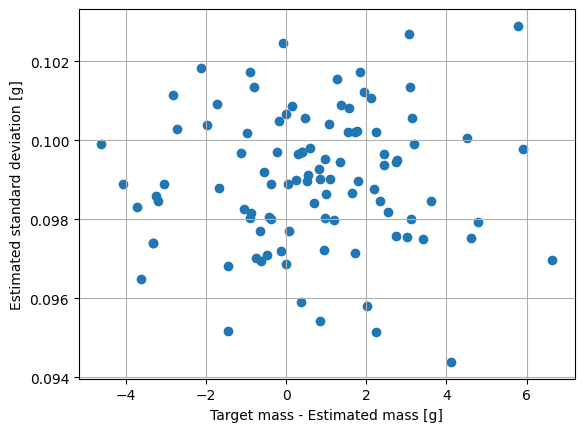

In [206]:
# 「計測した把持量-予測した把持量」 と 「予測した標準偏差」 の 散布図
plt.scatter(test_difference_mass_list, test_predict_sigma_list)
plt.grid()
plt.ylabel('Estimated standard deviation [g]')
plt.xlabel('Target mass - Estimated mass [g]')
#plt.savefig("test_scatter_mass_sd_6000epoch.pdf")
plt.show()

横軸：計測した把持量-MDNが予測した把持量  
縦軸：RNDのスコア

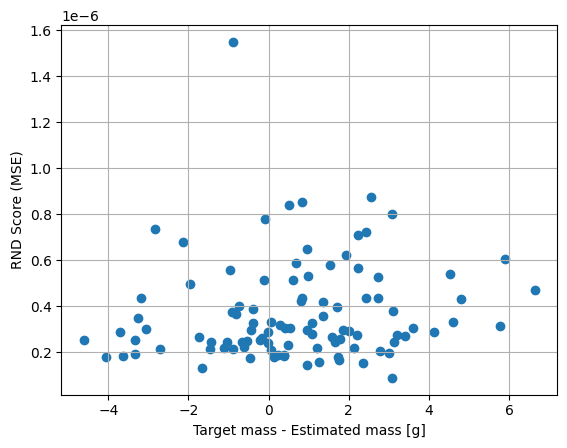

In [207]:
plt.scatter(test_difference_mass_list, test_rnd_score_list)
plt.grid()
plt.ylabel('RND Score (MSE)')
plt.xlabel('Target mass - Estimated mass [g]')
#plt.savefig("train_scatter_mass_sd_6000epoch.pdf")
plt.show()